In This Notebook, first half is for training the model. For testing, At later part I've created a simplified cell running which will call our trained mode, keeping hastle free from training it again and Testing the accuracy.

Note that: The zip files should be properly uploaded in the google drive for this code to work.

In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
!unzip "/content/drive/MyDrive/BrainTumourTraining(Dataset1).zip" -d /content/


Streaming output truncated to the last 5000 lines.
  inflating: /content/BrainTumourTraining(Dataset1)/glioma/Tr-gl_0715.jpg  
  inflating: /content/BrainTumourTraining(Dataset1)/glioma/Tr-gl_0716.jpg  
  inflating: /content/BrainTumourTraining(Dataset1)/glioma/Tr-gl_0717.jpg  
  inflating: /content/BrainTumourTraining(Dataset1)/glioma/Tr-gl_0718.jpg  
  inflating: /content/BrainTumourTraining(Dataset1)/glioma/Tr-gl_0719.jpg  
  inflating: /content/BrainTumourTraining(Dataset1)/glioma/Tr-gl_0720.jpg  
  inflating: /content/BrainTumourTraining(Dataset1)/glioma/Tr-gl_0721.jpg  
  inflating: /content/BrainTumourTraining(Dataset1)/glioma/Tr-gl_0722.jpg  
  inflating: /content/BrainTumourTraining(Dataset1)/glioma/Tr-gl_0723.jpg  
  inflating: /content/BrainTumourTraining(Dataset1)/glioma/Tr-gl_0724.jpg  
  inflating: /content/BrainTumourTraining(Dataset1)/glioma/Tr-gl_0725.jpg  
  inflating: /content/BrainTumourTraining(Dataset1)/glioma/Tr-gl_0726.jpg  
  inflating: /content/BrainTumourTrai

In [3]:
!pip install timm


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 125.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 85.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 63.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 20.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 109.7 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitl

In [4]:
import torch
import timm
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split


In [5]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),          # Convert image to tensor (required format)
    transforms.Normalize([0.485, 0.456, 0.406],   # Mean
                         [0.229, 0.224, 0.225])   # Std deviation
])


In [6]:
dataset = datasets.ImageFolder('/content/BrainTumourTraining(Dataset1)', transform=transform)


In [7]:
train_size = int(0.9 * len(dataset))  # 90% for training
val_size = len(dataset) - train_size  # 10% for validation

train_ds, val_ds = random_split(dataset, [train_size, val_size])


In [8]:
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=32)


In [9]:
# Load pretrained ViT model
model = timm.create_model('vit_base_patch16_224', pretrained=True)

# 4 classes
model.head = nn.Linear(model.head.in_features, 4)

# Send model to GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

In [10]:
import torch
print("GPU Available:", torch.cuda.is_available())
print("Device:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "CPU")


GPU Available: True
Device: Tesla T4


## Training Loop

In [11]:
# Loss function: measures how far predictions are from correct labels
criterion = nn.CrossEntropyLoss()

# Optimizer: updates model weights during training
optimizer = optim.Adam(model.parameters(), lr=3e-5)

epochs = 5  # number of times to loop over the full training data
epoch_losses = []  # to store average loss per epoch

# Training loop
for epoch in range(epochs):
    model.train()  # set model to training mode
    total_loss = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)  # move data to device

        optimizer.zero_grad()        # reset gradients
        outputs = model(inputs)      # forward pass (prediction)
        loss = criterion(outputs, labels)  # calculate loss
        loss.backward()              # backward pass (compute gradients)
        optimizer.step()             # update weights

        total_loss += loss.item()    # accumulate loss for printing

    avg_loss = total_loss / len(train_loader)
    epoch_losses.append(avg_loss)
    print(f"Epoch {epoch+1}, Loss: {avg_loss:.4f}")

#As This is The trickiest part I had to learn, I tried to add comments in all important lines

Epoch 1, Loss: 0.2514
Epoch 2, Loss: 0.0409
Epoch 3, Loss: 0.0249
Epoch 4, Loss: 0.0163
Epoch 5, Loss: 0.0122


In [12]:
model.eval()
correct, total = 0, 0

with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

accuracy = correct / total * 100
print(f"Validation Accuracy: {accuracy:.2f}%")


Validation Accuracy: 96.50%


Note: The model was tested across multiple runtime sessions. The validation accuracy remained consistently around 97%, with minor variations (e.g., 96–98%) due to the randomness in training/validation data splitting and weight initialization.

In [13]:
torch.save(model.state_dict(), "vit_brain_tumor.pth")


In [14]:
from google.colab import drive
drive.mount('/content/drive')

# Save to Drive
torch.save(model.state_dict(), '/content/drive/MyDrive/vit_brain_tumor.pth')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Visualization:**

## Training Loss per Epoch

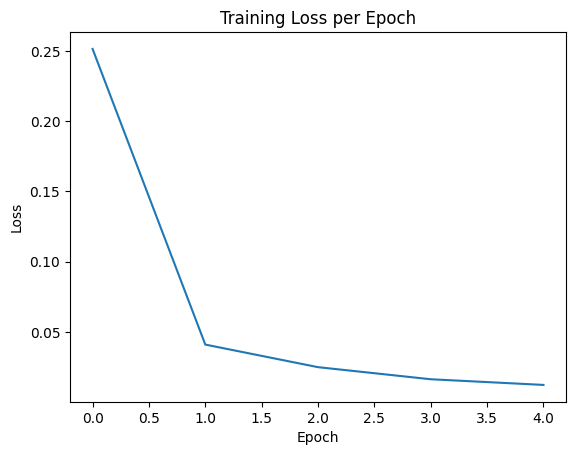

In [15]:
import matplotlib.pyplot as plt

plt.plot(epoch_losses)
plt.title("Training Loss per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()


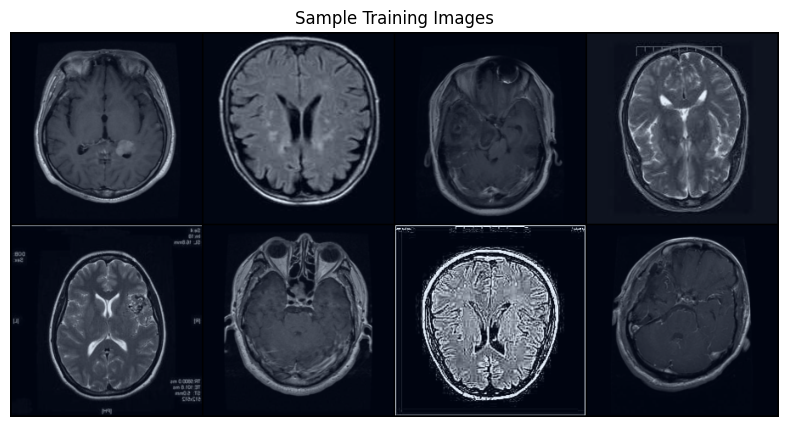

In [16]:
import matplotlib.pyplot as plt
import numpy as np
from torchvision.utils import make_grid
from torch.utils.data import DataLoader

def show_images(dataset, num=8):
    loader = DataLoader(dataset, batch_size=num, shuffle=True)
    images, labels = next(iter(loader))
    img_grid = make_grid(images, nrow=4, normalize=True)
    plt.figure(figsize=(10, 5))
    plt.imshow(np.transpose(img_grid.numpy(), (1, 2, 0)))
    plt.title("Sample Training Images")
    plt.axis('off')
    plt.show()

show_images(train_ds)


## A Sample view of Predictions

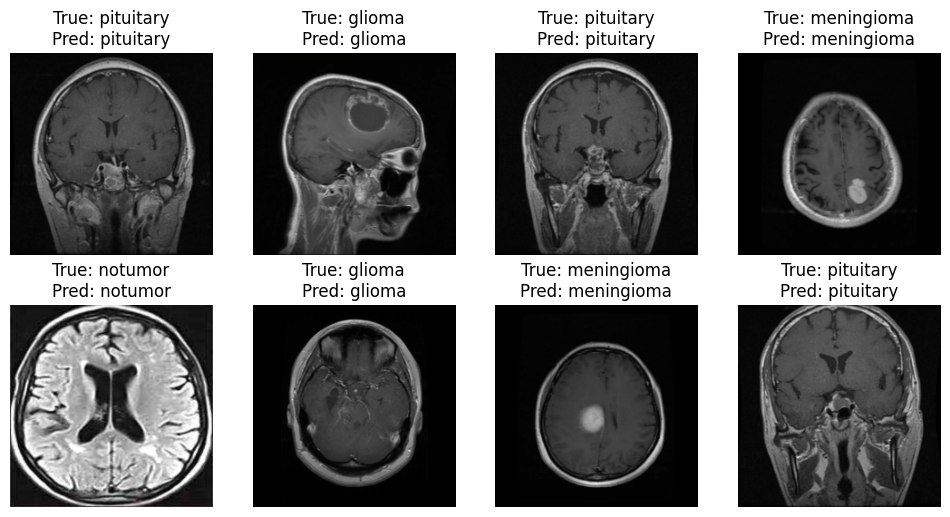

In [17]:
class_names = dataset.classes

def show_predictions(model, data_loader, num=8):
    model.eval()
    images, labels, preds = [], [], []

    with torch.no_grad():
        for inputs, lbls in data_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            images.extend(inputs.cpu())
            labels.extend(lbls)
            preds.extend(predicted.cpu())
            if len(images) >= num:
                break

    plt.figure(figsize=(12, 6))
    for i in range(num):
        plt.subplot(2, 4, i + 1)
        img = images[i].permute(1, 2, 0).numpy()
        img = np.clip(img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406]), 0, 1)
        plt.imshow(img)
        plt.title(f"True: {class_names[labels[i]]}\nPred: {class_names[preds[i]]}")
        plt.axis('off')
    plt.show()

show_predictions(model, val_loader)


## Confusion Matrix

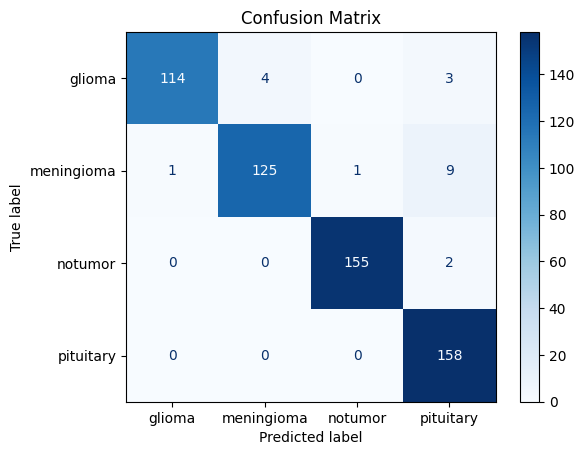

In [18]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_true, y_pred = [], []

model.eval()
with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=dataset.classes)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()


*Each time we dont need to train the model, rather, create same structure, Run This cell that will use our trained model and evaluate upcoming inputs*

In [19]:
from google.colab import drive
drive.mount('/content/drive')
import timm
import torch
import torch.nn as nn

# Load the model structure
model = timm.create_model('vit_base_patch16_224', pretrained=False)
model.head = nn.Linear(model.head.in_features, 4)  # 4 classes

# Load weights
model.load_state_dict(torch.load('/content/drive/MyDrive/vit_brain_tumor.pth', map_location='cpu'))

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
model.eval()  # set to evaluation mode




Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (patch_drop): Identity()
  (norm_pre): Identity()
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=False)
        (norm): Identity(

# Now We Will Test With Completely Seperate Dataset

In [20]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [21]:
!unzip "/content/drive/MyDrive/BrainTumourTesting(Dataset2).zip" -d /content/


Archive:  /content/drive/MyDrive/BrainTumourTesting(Dataset2).zip
   creating: /content/BrainTumourTesting(Dataset2)/
   creating: /content/BrainTumourTesting(Dataset2)/glioma/
  inflating: /content/BrainTumourTesting(Dataset2)/glioma/glioma (1).jpg  
  inflating: /content/BrainTumourTesting(Dataset2)/glioma/glioma (10).jpg  
  inflating: /content/BrainTumourTesting(Dataset2)/glioma/glioma (100).jpg  
  inflating: /content/BrainTumourTesting(Dataset2)/glioma/glioma (101).jpg  
  inflating: /content/BrainTumourTesting(Dataset2)/glioma/glioma (102).jpg  
  inflating: /content/BrainTumourTesting(Dataset2)/glioma/glioma (103).jpg  
  inflating: /content/BrainTumourTesting(Dataset2)/glioma/glioma (104).jpg  
  inflating: /content/BrainTumourTesting(Dataset2)/glioma/glioma (105).jpg  
  inflating: /content/BrainTumourTesting(Dataset2)/glioma/glioma (106).jpg  
  inflating: /content/BrainTumourTesting(Dataset2)/glioma/glioma (107).jpg  
  inflating: /content/BrainTumourTesting(Dataset2)/gliom

**Perform Transform
**

In [22]:
from torchvision import transforms, datasets
from torch.utils.data import DataLoader

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])


In [23]:

test_dataset = datasets.ImageFolder('/content/BrainTumourTesting(Dataset2)', transform=test_transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)



## Calling Model for evaluation

In [24]:
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

print(f"Test Accuracy: {correct / total * 100:.2f}%")


Test Accuracy: 95.36%


## Confusion Matrix

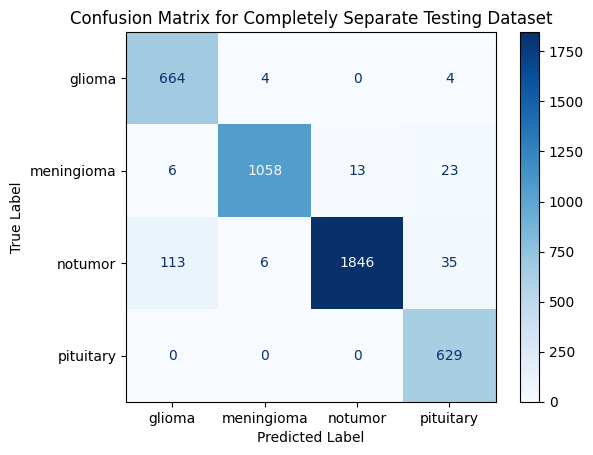

In [25]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Make predictions on the separate test set
y_true, y_pred = [], []

model.eval()
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

# Create confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Display it
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test_dataset.classes)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix for Completely Separate Testing Dataset")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


# Final Verdict:
> In the most of the runs , the model produced 97% accuracy for splitted unseen data from same dataset, And **95%** accuracy in completely Seperate Dataset.

> The model achieved **94 to 96% accuracy** on a completely separate testing dataset collected from a different source, indicating strong generalization.



> High caution was taken to ensure that the training and testing datasets were collected from completely separate and independently referenced sources.


 This high performance is likely due to the pretrained ViT model and consistent preprocessing, with no overlap or data leakage between training and testing sets.


**Sample UI For testing with any image**

In [26]:
from google.colab import files
from PIL import Image
import torch
from torchvision import transforms

#  Upload image
uploaded = files.upload()

#  Load and preprocess the image
image_path = next(iter(uploaded))
image = Image.open(image_path).convert('RGB')

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

input_tensor = transform(image).unsqueeze(0).to(device)  # add batch dimension

# Make prediction
model.eval()
with torch.no_grad():
    output = model(input_tensor)
    _, pred = torch.max(output, 1)

# Define class names explicitly
# These should match the folder names in your dataset
class_names = ['glioma', 'meningioma', 'notumor', 'pituitary']


#  Print predicted class
predicted_class = class_names[pred.item()]
print(f"Predicted Tumor Type: {predicted_class}")

Saving Te-me_0010.jpg to Te-me_0010.jpg
Predicted Tumor Type: meningioma
